In [106]:
# tar -xvf CommonVoice/Japanese.tar
# tar -xvf CommonVoice/Hindi.tar
# tar -xvf CommonVoice/Arabic.tar
# tar -xvf CommonVoice/Chinese_china.tar
# tar -xvf CommonVoice/Russian.tar
# tar -xvf CommonVoice/Spanish.tar
# tar -xvf CommonVoice/Portuguese.tar
# tar -xvf CommonVoice/Ukrainian.tar

import os
import glob
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import Normalize, Resize, imagenet_stats, cnn_learner, error_rate
from tqdm import tqdm

labels = ['hi', 'ja', 'ar', 'zh-CN', 'ru', 'es', 'pt', 'uk']
language_names = {
    'hi'   : 'Hindi',
    'ja'   : 'Japanese',
    'ar'   : 'Arabic',
    'zh-CN': 'Chinese (China)',
    'ru'   : 'Russian',
    'es'   : 'Spanish',
    'pt'   : 'Portuguese',
    'uk'   : 'Ukrainian'
}

# when you untar the data, it ends up in this folder.
data_path = Path('./cv-corpus-6.1-2020-12-11')

# where the folds are stored. Each fold is a directory containing 1/10th of the data in
# the folder 'valid', and 9/10ths of the data in the folder 'train'
folds_path = data_path/'folds'

# where to store spectrograms if you only want to train on a subset of languages, but don't want to delete the folds.
folds_temp = data_path/'folds_temp'


In [193]:
# language is the language code (e.g. 'hi' for Hindi, 'ja' for Japanese)
def create_language_spectrograms(language, start):
    spectrogram_path = data_path/language/'spectrograms'
    print(f'Converting audio for {language_names[language]} into spectrograms')
    if not os.path.isdir(spectrogram_path):
        os.mkdir(spectrogram_path)

    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    for i, audio_file in enumerate(tqdm(list(Path(data_path/language/'clips').glob('*.mp3')))):
        if i < start:
            continue
        # If you get an error here, you may need to install FFmpeg.
        # FFmpeg is a utility that librosa uses to open mp3 files on some platforms.
        # Make sure that the command line you start your jupyter notebook server in has access to ffmpeg
        samples, sample_rate = librosa.load(audio_file)
        filename = spectrogram_path/Path(audio_file).name.replace('.mp3','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close('all')
    
def setup_fold_directories(setup_path):
    if (os.path.isdir(setup_path)):
        print(f"Directory {setup_path} already exists, skipping setup of directory hierarchy.")
        return
    # create folders for each fold
    os.mkdir(setup_path)
    for fold_num in range(1, 11):
        fold = str(fold_num)
        os.mkdir(setup_path/fold)
        os.mkdir(setup_path/fold/'train')
        os.mkdir(setup_path/fold/'valid')
    return
 
def partition_into_folds(language):
    print(f'Partitioning spectrograms for {language_names[language]} into folds')
    spectrogram_path = data_path/language/'spectrograms'
    png_files = list(spectrogram_path.glob('*.png'))
    
    # make the folders for this language in the train and valid directories of each fold
    for fold_num in range(1, 11):
        fold = str(fold_num)
        os.mkdir(folds_path/fold/'train'/language)
        os.mkdir(folds_path/fold/'valid'/language)
    for file_num, file in enumerate(tqdm(list(png_files))):
        # this is the fold for which this file is in the validation set
        valid_fold_num = file_num % 10 + 1
        for fold_num in range(1, 11):
            fold = str(fold_num)
            if fold_num == valid_fold_num:
                shutil.copyfile(file, folds_path/fold/'valid'/language/file.name)
            else:
                shutil.copyfile(file, folds_path/fold/'train'/language/file.name)

setup_fold_directories(folds_path)
setup_fold_directories(folds_temp)

# create_language_spectrograms('hi', 0)
# create_language_spectrograms('ja', 0)
# create_language_spectrograms('ar', 0)
# create_language_spectrograms('zh-CN', 0)
# create_language_spectrograms('ru', 0) 
# create_language_spectrograms('es', 0)
# create_language_spectrograms('pt', 0)
# create_language_spectrograms('uk', 0)

# partition_into_folds('hi')
# partition_into_folds('ja')
# partition_into_folds('ar')
# partition_into_folds('zh-CN')
# partition_into_folds('ru')
# partition_into_folds('es')
# partition_into_folds('pt')
partition_into_folds('uk')

Directory cv-corpus-6.1-2020-12-11\folds already exists, skipping setup of directory hierarchy.
Directory cv-corpus-6.1-2020-12-11\folds_temp already exists, skipping setup of directory hierarchy.
Partitioning spectrograms for Ukrainian into folds


100%|██████████████████████████████████████████████████████████████████████████████| 3050/3050 [01:02<00:00, 48.97it/s]


In [195]:
def move_language_folds(language):
    for fold_num in range(1, 11):
        fold = str(fold_num)
        shutil.move(folds_path/fold/'train'/language, folds_temp/fold/'train'/language)
        shutil.move(folds_path/fold/'valid'/language, folds_temp/fold/'valid'/language)

def unmove_language_folds(language):
    for fold_num in range(1, 11):
        fold = str(fold_num)
        shutil.move(folds_temp/fold/'train'/language, folds_path/fold/'train'/language)
        shutil.move(folds_temp/fold/'valid'/language, folds_path/fold/'valid'/language)

# move_language_folds('ar')
move_language_folds('es')
# move_language_folds('hi')
# move_language_folds('ja')
# move_language_folds('ru')
# move_language_folds('zh-CN')
move_language_folds('pt')
# move_language_folds('uk')

# unmove_language_folds('es')
unmove_language_folds('ru')

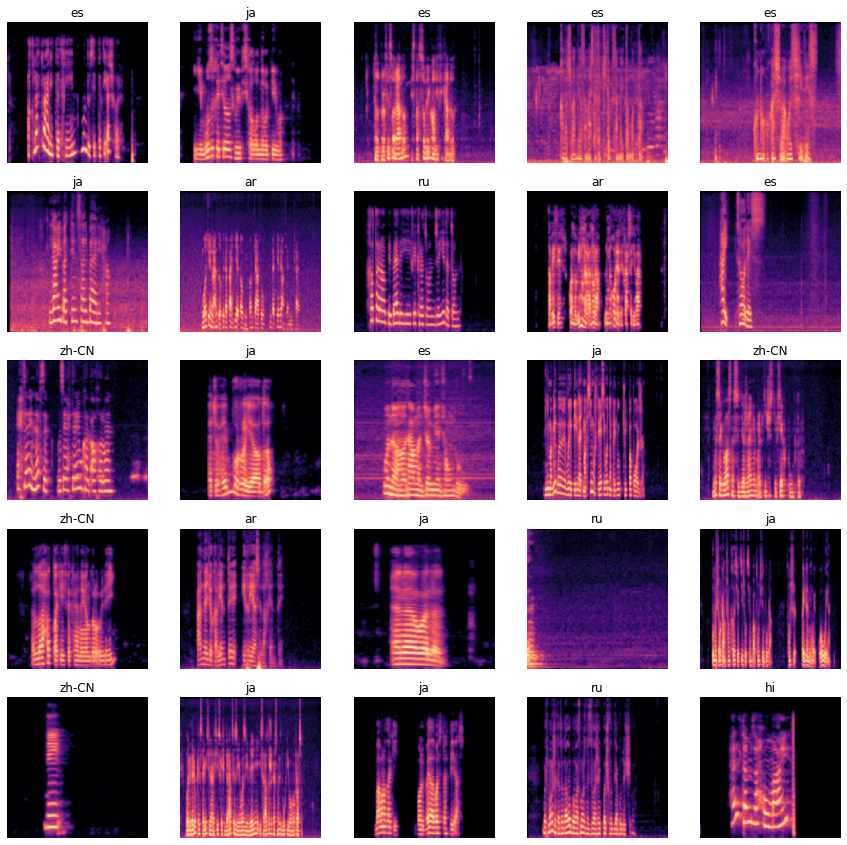

In [111]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# don't use any transformations because it doesn't make sense in the case of a spectrogram
# i.e. flipping a spectrogram changes the meaning
data = ImageDataLoaders.from_folder(folds_path/'1', 
                                    item_tfms=Resize(224), 
                                    batch_tfms=Normalize.from_stats(*imagenet_stats))
data.show_batch(max_n=25)

In [196]:
def process_fold(fold):
    data = ImageDataLoaders.from_folder(folds_path/fold, 
                                    item_tfms=Resize(224), 
                                    batch_tfms=Normalize.from_stats(*imagenet_stats),
                                    num_workers=0)
    learn = cnn_learner(data, models.resnet34, metrics=error_rate) 
    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(1)
    learn.fit_one_cycle(3, lr_max=slice(1e-6,1e-4))

In [197]:
process_fold('1')

epoch,train_loss,valid_loss,error_rate,time
0,0.515763,0.252663,0.097039,01:54
1,0.275280,0.171012,0.059211,00:38
2,0.194422,0.160159,0.055921,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.174608,0.071462,0.023026,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.075383,0.054244,0.019737,00:46
1,0.066971,0.047871,0.014803,00:46
2,0.061247,0.049266,0.014803,00:46


In [198]:
process_fold('2')

epoch,train_loss,valid_loss,error_rate,time
0,0.542627,0.291495,0.120066,01:56
1,0.313749,0.191290,0.069079,00:38
2,0.210452,0.172083,0.064145,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.206049,0.075482,0.029605,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.088109,0.069690,0.023026,00:46
1,0.079407,0.057650,0.019737,00:45
2,0.072575,0.057540,0.019737,00:45


In [199]:
process_fold('3')

epoch,train_loss,valid_loss,error_rate,time
0,0.518681,0.269991,0.095395,01:56
1,0.307143,0.159285,0.052632,00:38
2,0.200866,0.132864,0.042763,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.155068,0.059624,0.019737,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.072174,0.049713,0.014803,00:45
1,0.062191,0.046365,0.014803,00:46
2,0.054059,0.045059,0.018092,00:46


In [200]:
process_fold('4')

epoch,train_loss,valid_loss,error_rate,time
0,0.540345,0.232174,0.082237,01:54
1,0.297992,0.184060,0.064145,00:38
2,0.197717,0.173718,0.057566,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.189561,0.110815,0.036184,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.091862,0.073817,0.034539,00:45
1,0.074891,0.066024,0.032895,00:45
2,0.065913,0.065687,0.023026,00:46


In [201]:
process_fold('5')

epoch,train_loss,valid_loss,error_rate,time
0,0.557180,0.247872,0.093750,01:53
1,0.304081,0.170762,0.052632,00:38
2,0.196601,0.154770,0.041118,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.180645,0.081277,0.027961,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.074888,0.071782,0.023026,00:46
1,0.071375,0.066057,0.021382,00:46
2,0.062516,0.064256,0.021382,00:45


In [202]:
process_fold('6')

epoch,train_loss,valid_loss,error_rate,time
0,0.549988,0.309971,0.123355,01:55
1,0.302750,0.210124,0.075658,00:38
2,0.200697,0.189677,0.074013,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.163297,0.086462,0.023026,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.072881,0.080967,0.019737,00:46
1,0.062620,0.076628,0.021382,00:46
2,0.058930,0.073731,0.019737,00:45


In [203]:
process_fold('7')

epoch,train_loss,valid_loss,error_rate,time
0,0.531316,0.258399,0.101974,01:54
1,0.299212,0.189007,0.077303,00:40
2,0.211600,0.177722,0.070724,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.175836,0.085397,0.023026,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.084269,0.073747,0.027961,00:46
1,0.077812,0.068201,0.021382,00:46
2,0.064323,0.066366,0.023026,00:46


In [204]:
process_fold('8')

epoch,train_loss,valid_loss,error_rate,time
0,0.536399,0.257563,0.101974,01:51
1,0.301956,0.166260,0.054276,00:39
2,0.200893,0.143148,0.052632,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.173787,0.065884,0.024671,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.072759,0.052472,0.019737,00:46
1,0.063522,0.047652,0.018092,00:46
2,0.055181,0.045606,0.016447,00:46


In [205]:
process_fold('9')

epoch,train_loss,valid_loss,error_rate,time
0,0.537202,0.243733,0.084020,01:52
1,0.306432,0.152154,0.052718,00:39
2,0.199455,0.137268,0.051071,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.190923,0.049347,0.014827,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.086818,0.040590,0.009885,00:45
1,0.070861,0.037507,0.013180,00:45
2,0.068485,0.036259,0.009885,00:45


In [206]:
process_fold('10')

epoch,train_loss,valid_loss,error_rate,time
0,0.507630,0.290262,0.100494,01:52
1,0.304856,0.198719,0.065898,00:38
2,0.204624,0.168210,0.052718,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.159167,0.069474,0.021417,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.067547,0.055567,0.016474,00:45
1,0.060516,0.052304,0.018122,00:46
2,0.047264,0.048568,0.019769,00:47


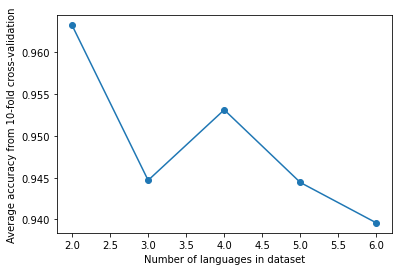

In [177]:
# Japanese, Arabic
error_rates_2_langs = [0.038052, 0.035008, 0.032012, 0.044207, 0.041159, 0.038110, 0.033537, 0.039634, 0.022901, 0.042748]

# Japanese, Arabic, Chinese
error_rates_3_langs = [0.052083, 0.044838, 0.052192, 0.056367, 0.068894, 0.060543, 0.056367, 0.062630, 0.043887, 0.055381]

# Japanese, Arabic, Chinese, Russian
error_rates_4_langs = [0.039588, 0.049921, 0.045995, 0.048374, 0.057891, 0.054718, 0.046788, 0.038858, 0.043685, 0.042891]

# Japanese, Arabic, Chinese, Russian, Spanish
error_rates_5_langs = [0.058824, 0.049264, 0.052497, 0.055058, 0.061460, 0.063380, 0.058899, 0.056978, 0.047466, 0.051956]

# Japanese, Arabic, Chinese, Russian, Spanish, Hindi
error_rates_6_langs = [0.063961, 0.052308, 0.060961, 0.062192, 0.065887, 0.070813, 0.054803, 0.057882, 0.050617, 0.064815]

error_rates = [error_rates_2_langs, error_rates_3_langs, error_rates_4_langs, error_rates_5_langs, error_rates_6_langs]
accuracies = []
for rates in error_rates:
    accuracy = 1 - sum(rates) / 10
    accuracies.append(accuracy)

plt.plot(list(range(2,7)), accuracies, '-o')
plt.ylabel('Average accuracy from 10-fold cross-validation')
plt.xlabel('Number of languages in dataset')
plt.show()

In [207]:
pt_vs_es_error_rates = [0.034711, 0.028099, 0.031405, 0.039669, 0.033058, 0.034711, 0.039735, 0.024834, 0.033167, 0.033167]
uk_vs_ru_error_rates = [0.014803, 0.019737, 0.018092, 0.023026, 0.021382, 0.019737, 0.023026, 0.016447, 0.009885, 0.019769]

accuracy = 1 - sum(pt_vs_es_error_rates) / 10
print(f"Overall accuracy for Portuguese vs Spanish was {accuracy * 100}%")

accuracy = 1 - sum(uk_vs_ru_error_rates) / 10
print(f"Overall accuracy for Ukrainian vs Russian was {accuracy * 100}%")

Overall accuracy for Portuguese vs Spanish was 96.67443999999999%
Overall accuracy for Ukrainian vs Russian was 98.14095999999999%
